# Лабораторная работа №4

Бирюков В. В.

Группа: М8О-407Б-19

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import defaultdict
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

cudnn.benchmark = True

In [2]:
%matplotlib inline

## Загрузка данных

Датасет [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) содержит изображения шести классов:
* buildings
* forest
* glacier
* mountain
* sea
* street

Тренировная выборка содержит 14000 изображений, валидационная - 3000

In [4]:
from google.colab import files
files.upload()
pass

Saving kaggle.json to kaggle.json


In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 333M/346M [00:01<00:00, 131MB/s]
100% 346M/346M [00:01<00:00, 187MB/s]


In [8]:
!unzip -q intel-image-classification

In [ ]:
# Аугментация данных производится только для тренивочных изображений
# Валидационные только нормируются и приводятся к нужному размеру
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {'train': datasets.ImageFolder('seg_train/seg_train', data_transforms['train']),
                 'val': datasets.ImageFolder('seg_test/seg_test', data_transforms['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

In [ ]:
# Функция отрисовки изображения
def plot_image(ax, image, interp='nearest'):    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(aspect='equal')
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Изображение транспонируется из 3xHxW в HxWx3, нормализуется и обрезается в диапазон 0-1
    ax.imshow(np.clip(np.array(image).transpose(1, 2, 0) * std + mean, 0, 1), interpolation=interp)

# Функция отрисовки нескольких изображений в сетке с опциональными подписями
def plot_images(images, indexes=None, w=7, h=None, titles=None, interp='nearest'):
    indexes = range(len(images)) if indexes is None else indexes
    
    h = h or (len(indexes) - 1) // w + 1
    assert(w * h >= len(indexes))
    
    fig = plt.figure(figsize=(w * 3, h * 3))
    for i, k in enumerate(indexes, 1):
        ax = fig.add_subplot(h, w, i)
        plot_image(ax, images[k], interp=interp)
        if titles is not None and k < len(titles):
            ax.set_title(titles[k])
    fig.subplots_adjust(wspace=0.15, hspace=0.15)
    
    plt.show()

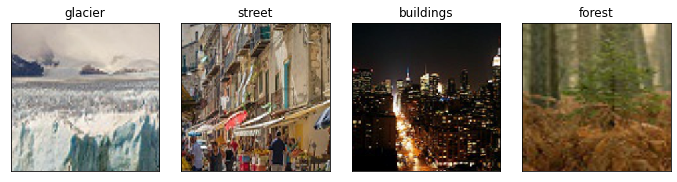

In [ ]:
# Визуализация батча тренировочных данных
inputs, classes = next(iter(dataloaders['train']))

plot_images(inputs, titles=[class_names[x] for x in classes])

## Обучение

In [ ]:
# Функция обучения
def train_model(model, criterion, optimizer, scheduler, epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = defaultdict(list)
    
    # Отслеживание прогресса при помощи tqdm вместо постоянной печати
    pbar = tqdm.trange(epochs)
    for epoch in pbar:
        # Каждая эпоха имеет фазу тренировки и валидация
        for phase in ['train', 'val']:
            # Перевод модели в необходимый режим
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Обратный проход и оптимизация только при в режиме обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Обновление лосса и числа правильных предсказаний
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # Изменение lr в конце эпохи в режиме обучения
            if phase == 'train':
                scheduler.step()
            
            # Средний лосс и точность по эпохе
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Сохранение промежуточных значений
            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc.item())

            # Копирование модели, если она лучше предыдущих
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Обновление подписи
        pbar.set_description(f"Epoch: {epoch}. Train loss: {history['train_loss'][-1]:.4f}. Val loss: {history['val_loss'][-1]:.4f}. Train acc: {history['train_acc'][-1]:.4f}. Val acc: {history['val_acc'][-1]:.4f}")

    time_elapsed = time.time() - since
    print()
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Загрузка весов лучшей модели
    model.load_state_dict(best_model_wts)

    # Очистка кэша
    with torch.no_grad():
        torch.cuda.empty_cache()

    return model, history

### Визуализация результатов

In [ ]:
# Функция отрисовки графиков метрик
def plot_history(history, *metrics):
    for metric in metrics:
        for phase in ['train_', 'val_']:
            print(f"{phase+metric}: {history[phase+metric][-1]:.4f}")
    figure = plt.figure(figsize=(8 * len(metrics), 5))
    for i, metric in enumerate(metrics, 1):
        ax = figure.add_subplot(1, len(metrics), i)
        ax.xaxis.get_major_locator().set_params(integer=True)
        ax.set_title(metric)
        for phase in ['train', 'val']:
            ax.plot(history[phase + '_' + metric], '-', label=phase)
        ax.legend()
    plt.show()

# Функция визуализации предсказаний
def plot_results(model, num_images=6):
    was_training = model.training
    model.eval()
    images = []
    titles = []
    
    # Сбор изображений и предсказаний
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images.append(inputs[j].cpu())
                titles.append(class_names[preds[j]])
                
                # Если предсказание неверно - истиный класс будет указан в скобках
                if preds[j] != labels[j]:
                    titles[-1] += f' ({class_names[labels[j]]})'

                if len(images) == num_images:
                    break

            if len(images) == num_images:
                    break
        model.train(mode=was_training)
        
    plot_images(images, titles=titles)

# Так как многоклассовая классификация, выведем также confusion matrix
def plot_confusion_matrix(model):
    was_training = model.training
    model.eval()
    target = []
    pred = []
    
    # Сбор предсказаний и истиных значений
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            target.extend(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            pred.extend(preds.detach().cpu())

        model.train(mode=was_training)

    conf = confusion_matrix(target, pred)

    fig = plt.figure(figsize=(7.5, 6))
    ax = fig.gca()
    sns.heatmap(conf, cmap='viridis', xticklabels=class_names, yticklabels=class_names, square=True, annot=True, fmt='d', ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
    plt.show()

## Обучение модели полностью

In [ ]:
# Загрузка модели - предобученный resnet18
model_ft = models.resnet18(weights='DEFAULT')

# Замена последнего полносвязного слоя, на слой с нужным размером выхода
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Функция ошибки
criterion = nn.CrossEntropyLoss()

# Оптимизатор - обучаем все веса
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Шедулер - lr умножается на 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Обучение и тестирование

In [ ]:
model_ft, ft_history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=25)

Epoch: 24. Train loss: 0.2895. Val loss: 0.2120. Train acc: 0.8975. Val acc: 0.9303: 100%|██████████| 25/25 [43:56<00:00, 105.44s/it]


Training complete in 43m 56s
Best val Acc: 0.930333


train_loss: 0.2895
val_loss: 0.2120
train_acc: 0.8975
val_acc: 0.9303


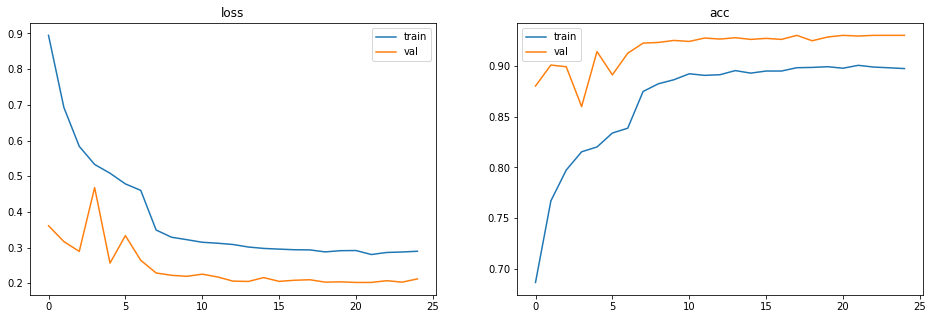

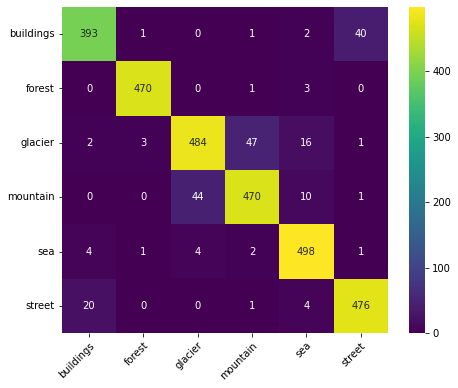

In [ ]:
plot_history(ft_history, 'loss', 'acc')
plot_confusion_matrix(model_ft)

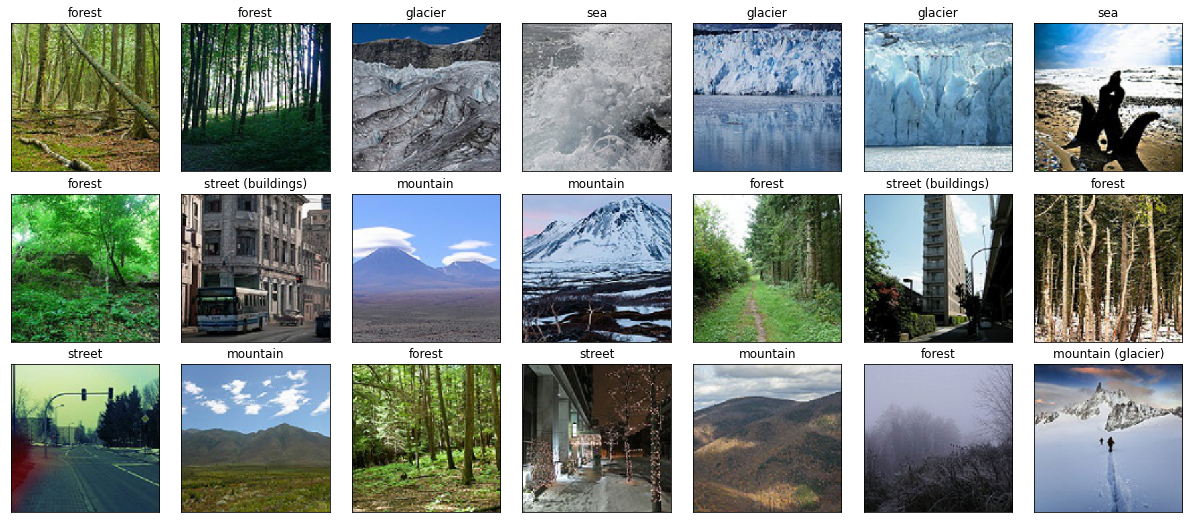

In [ ]:
plot_results(model_ft, 21)

## Обучение только последнего слоя

In [ ]:
# Загрузка модели - предобученный resnet18
model_conv = torchvision.models.resnet18(weights='DEFAULT')
# Отключение вычисления градиентов для всех слоев
for param in model_conv.parameters():
    param.requires_grad = False

# Замена последнего полносвязного слоя, на слой с нужным размером выхода
# requires_grad новых слоев равно True по умолчанию
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Оптимизатор - обучаем только последний слой
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Шедулер - lr умножается на 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Обучение и тестирование

In [ ]:
model_conv, conv_history = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, epochs=25)

Epoch: 24. Train loss: 0.6603. Val loss: 0.3181. Train acc: 0.7624. Val acc: 0.8983: 100%|██████████| 25/25 [26:24<00:00, 63.39s/it]


Training complete in 26m 25s
Best val Acc: 0.899667


train_loss: 0.6603
val_loss: 0.3181
train_acc: 0.7624
val_acc: 0.8983


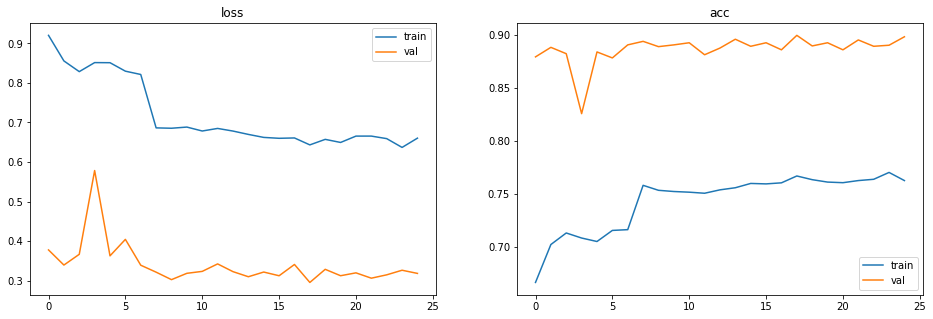

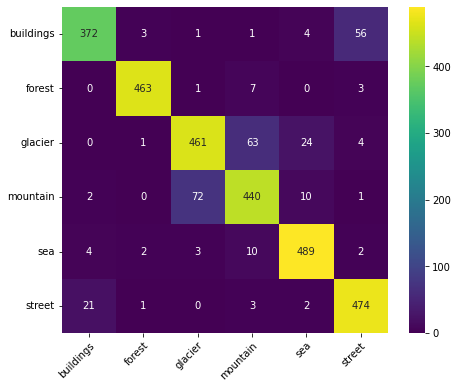

In [ ]:
plot_history(conv_history, 'loss', 'acc')
plot_confusion_matrix(model_conv)

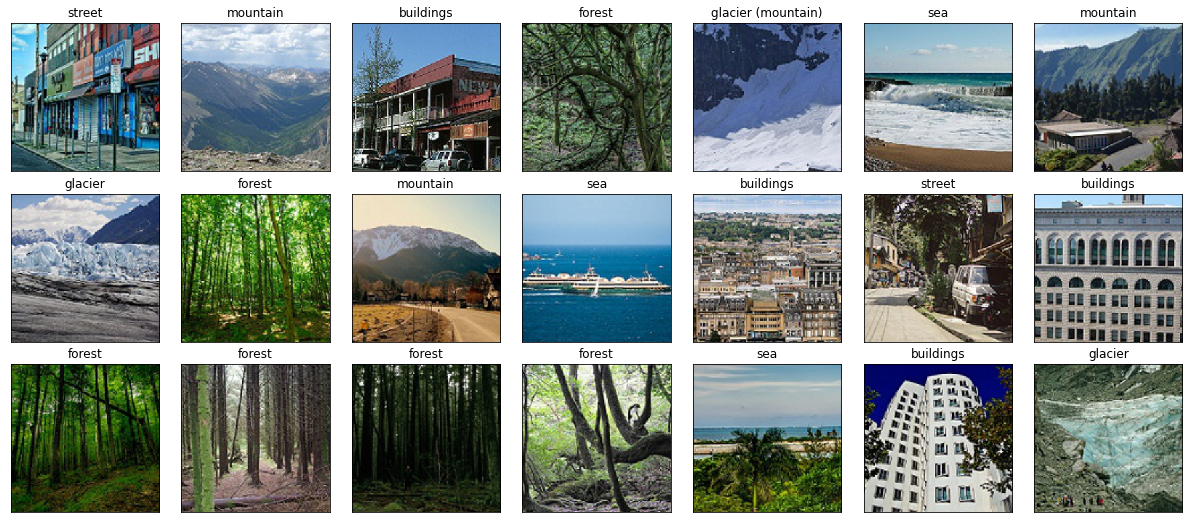

In [ ]:
plot_results(model_conv, 21)

## Выводы

В целом resnet18 справляется с поставленной задачей, путаясь только в похожих классах (buildings/street, glacier/mountain). При одинаковом числе эпох и параметрах, обучение сети целиком дает лучшие результаты чем обучение только последнего слоя, но требует значительно больше времени. По графикам также видно, что до переобучения далеко, а значит модели можно обучать еще дольше, с потенциальным улучшением результата.